### Notebook 6: Optimizing the detection thresholds and minimum mask areas

In [1]:
import numpy as np
import os
from pathlib import Path
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
import cv2
import matplotlib.pyplot as plt
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import pycocotools.mask as mask_util

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
dataDir=Path('../')
register_coco_instances('sartorius_val',{},'../sartorius-annotations-coco-format/annotations_val.json', dataDir)

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = 'output_1.2/model_finetuned_best.pth'
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.DATASETS.TEST = ("sartorius_val",)
predictor = DefaultPredictor(cfg)

In [4]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1
    false_positives = np.sum(matches, axis=0) == 0
    false_negatives = np.sum(matches, axis=1) == 0
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= score_threshold[pred_class]
    pred_masks = pred['instances'].pred_masks[take].cpu().numpy()
    enc_preds = []
    used = np.zeros(pred_masks[0].shape, dtype=int)
    for mask in pred_masks:
        mask = (mask * (1-used)).astype(bool)
        if mask.sum() >= min_mask_area[pred_class]:
            used += mask
            enc_preds.append(mask_util.encode(np.asarray(mask, order='F')) )
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"mAP IoU": np.mean(self.scores)}

In [5]:
evaluator = MAPIOUEvaluator("sartorius_val")
val_loader = build_detection_test_loader(cfg, "sartorius_val")

In [8]:
# Optimizing the threshold of the third class
min_mask_area = [0, 0, 0]
score_threshold = [.0, .0, .0]
l_thresh = np.linspace(0.1,0.75,26)
l_mAP = []
for thresh in l_thresh:
    score_threshold[0] = thresh
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])

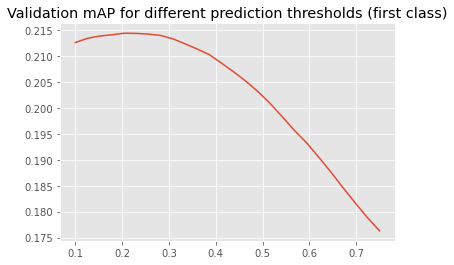

In [14]:
plt.plot(l_thresh,l_mAP)
plt.title("Validation mAP for different prediction thresholds (first class)");

In [15]:
l_thresh[np.argmax(l_mAP)]

0.20400000000000001

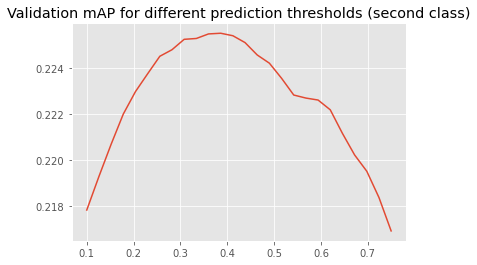

In [17]:
# Optimizing the threshold of the second class
score_threshold = [.204, .0, .0]
l_thresh = np.linspace(0.1,0.75,26)
l_mAP = []
for thresh in l_thresh:
    score_threshold[1] = thresh
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])
plt.plot(l_thresh,l_mAP)
plt.title("Validation mAP for different prediction thresholds (second class)");

In [18]:
l_thresh[np.argmax(l_mAP)]

0.386

/home/hamdi/miniconda3/envs/env/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


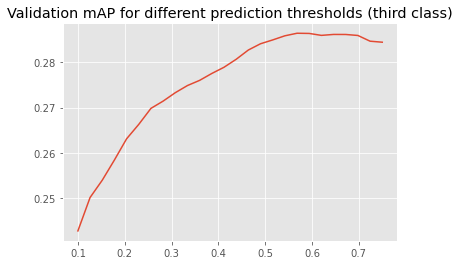

In [19]:
# Optimizing the threshold of the third class
score_threshold = [.204, 0.386, .0]
l_thresh = np.linspace(0.1,0.75,26)
l_mAP = []
for thresh in l_thresh:
    score_threshold[2] = thresh
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])
plt.plot(l_thresh,l_mAP)
plt.title("Validation mAP for different prediction thresholds (third class)");

In [20]:
l_thresh[np.argmax(l_mAP)]

0.5680000000000001

In [22]:
# we retain the following thresholds:
score_threshold = [0.204, 0.386, 0.568]

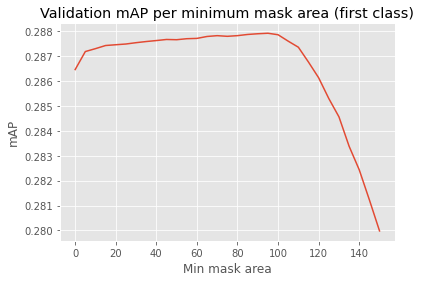

In [32]:
# Optimizing the minimum mask area of the first class (in pixels)
min_mask_area = [0, 0, 0]
l_min_area = np.linspace(0,150,31)
l_mAP = []
for min_area in l_min_area:
    min_mask_area[0] = min_area
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])
plt.plot(l_min_area,l_mAP)
plt.xlabel("Min mask area")
plt.ylabel("mAP")
plt.title("Validation mAP per minimum mask area (first class)");

In [37]:
l_min_area[np.argmax(l_mAP)]
# mAP is almost constant between 60 and 100 but then it decreases sharply. To be cautious we'll set the min mask area to 75

95.0

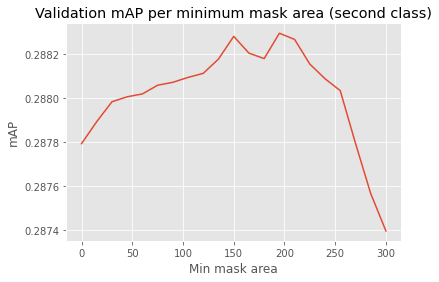

In [43]:
# Optimizing the minimum mask area of the second class (in pixels)
min_mask_area = [75, 0, 0]
l_min_area = np.linspace(0,300,21)
l_mAP = []
for min_area in l_min_area:
    min_mask_area[1] = min_area
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])
plt.plot(l_min_area,l_mAP)
plt.xlabel("Min mask area")
plt.ylabel("mAP")
plt.title("Validation mAP per minimum mask area (second class)");

In [44]:
l_min_area[np.argmax(l_mAP)]
# There is very little variability in the mAP. We'll choose the minimum mask area equal to 180

195.0

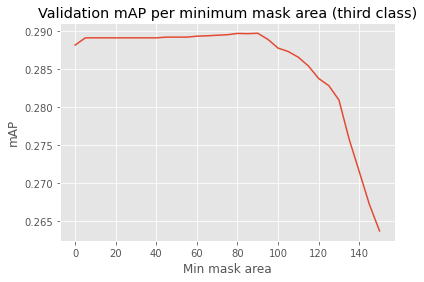

In [46]:
# Optimizing the minimum mask area of the third class (in pixels)
min_mask_area = [75, 180, 0]
l_min_area = np.linspace(0,150,31)
l_mAP = []
for min_area in l_min_area:
    min_mask_area[2] = min_area
    l_mAP.append(inference_on_dataset(predictor.model, val_loader, evaluator)["mAP IoU"])
plt.plot(l_min_area,l_mAP)
plt.xlabel("Min mask area")
plt.ylabel("mAP")
plt.title("Validation mAP per minimum mask area (third class)");

In [48]:
l_min_area[np.argmax(l_mAP)]
# We choose the minimum mask area equal to 75

90.0

In [ ]:
# best parameters
score_threshold = [0.204, 0.386, 0.568]
min_mask_area = [75, 180, 75]